In [1]:
import splitfolders

In [2]:
# Librerías estándar 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import math 

In [3]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Importar módulos y funciones de TensorFlow
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [4]:
foto1 = plt.imread('Datos/Imagenes/Bosones_Z/el0.jpg')

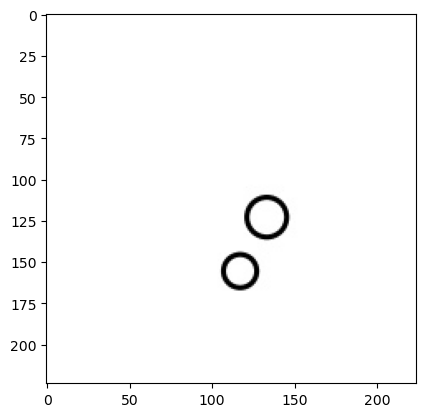

In [5]:
plt.imshow(foto1)

In [6]:
splitfolders.ratio("Datos/Imagenes","processed_data", seed=42, ratio=(.6,.2,.2))

In [7]:
# Separa memoria
img_height,img_width = (224,224)
batch_size = 32
train_data_dir = "processed_data/train"
valid_data_dir = "processed_data/val"
test_data_dir = "processed_data/test"

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip=True,
                                  validation_split=0.4)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = 'categorical',
    subset ='training') #set as training data

Found 314 images belonging to 2 classes.


In [10]:
valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, #same directory training data
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation') #set as validation data 

Found 68 images belonging to 2 classes.


In [11]:
  test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = 'categorical',
    subset = 'validation') #set as validation data 

Found 68 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(train_generator.num_classes,activation='softmax')(x)
model = Model(inputs=base_model.input,outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False  

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator,
                       epochs = 10 )

In [ ]:
model.save('Model/ResNet50_Electrons.h5')

In [ ]:
test_loss,test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy: ', test_acc)

In [ ]:
import tensorflow as tf
import seaborn as sn
model = tf.keras.models.load_model('Model/ResNet50_Electrons.h5')
filenames = test_generator.filenames

In [ ]:
nb_samples = len(test_generator)
y_prob = []
y_act = []
test_generator.reset()

In [ ]:
for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

In [ ]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

In [ ]:
out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, columns=['predicted_class','actual_class'])

In [ ]:
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

In [ ]:
sn.heatmap(confusion_matrix,cmap='Reds',annot=True,fmt='d')
plt.show()
print('test_accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))